In [74]:
import numpy as np
import cv2 
import os
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob

## Utils

In [42]:
def intersection(line1, line2):
    # Cartesian coordinates (x1, y1, x2, y2)
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    
    # Calculate the determinant
    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    
    if denom == 0:
        return None  # Lines are parallel or coincident
    
    # Calculate the intersection point
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denom
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denom
    
    return (int(intersect_x), int(intersect_y))

def filter_nearby_intersections(intersections, threshold=10):
    """
    Filters out intersections that are within the given threshold distance.
    
    Args:
    - intersections: List of intersection points (x, y).
    - threshold: The distance below which intersections are considered duplicates (default 10 pixels).
    
    Returns:
    - A list of unique intersection points.
    """
    filtered = []
    
    for point in intersections:
        add_point = True
        for filtered_point in filtered:
            # Calculate Euclidean distance between the current point and each filtered point
            dist = np.sqrt((point[0] - filtered_point[0]) ** 2 + (point[1] - filtered_point[1]) ** 2)
            if dist < threshold:
                add_point = False  # Don't add this point, it's too close to an existing one
                break
        if add_point:
            filtered.append(point)
    
    return filtered

def perspective_transform(image, corners, im_size=900):
    # Define the width and height for the output square
    width, height = im_size, im_size
    
    # Define the destination points (square corners in the destination image)
    dst_points = np.array([
        [0, 0],  # top-left
        [width - 1, 0],  # top-right
        [width - 1, height - 1],  # bottom-right
        [0, height - 1]  # bottom-left
    ], dtype="float32")
    
    # If 4 corners are detected, proceed
    if len(corners) == 4:
        # Sort the corners in a consistent order
        sorted_corners = sorted(corners, key=lambda x: (x[1], x[0]))  # Sort by y-coordinate first, then by x-coordinate
        
        # Now that we have the sorted corners, we need to assign them to top-left, top-right, bottom-left, bottom-right
        (tl, tr, br, bl) = sorted_corners
        
        # Further classify based on x-coordinate (top-left vs top-right and bottom-left vs bottom-right)
        if tl[0] > tr[0]:
            tl, tr = tr, tl
        if bl[0] > br[0]:
            bl, br = br, bl
        
        # Define the source points from the detected corners
        src_points = np.array([tl, tr, br, bl], dtype="float32")
        
        # Compute the perspective transform matrix
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        
        # Apply the perspective transformation
        transformed_image = cv2.warpPerspective(image, M, (width, height))
        
        return transformed_image
    else:
        return None

def calculate_angle(line1, line2):
    # Extract coordinates from the lines
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    
    # Calculate direction vectors
    vector1 = np.array([x2 - x1, y2 - y1])
    vector2 = np.array([x4 - x3, y4 - y3])
    
    # Compute dot product and magnitudes
    dot_product = np.dot(vector1, vector2)
    mag1 = np.linalg.norm(vector1)
    mag2 = np.linalg.norm(vector2)
    
    # Calculate the cosine of the angle
    cos_theta = dot_product / (mag1 * mag2)
    
    # Ensure cos_theta is within valid range for acos to avoid errors due to floating point precision
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_rad = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def find_bounding_rectangle(blob):
    # find 4 longest lines
    edges = cv2.Canny(blob, 150, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=100)
    line_details = []
    
    # Calculate the length of each line and store the details
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            line_details.append((x1, y1, x2, y2, length))
    
    # Sort the lines by length in descending order
    line_details.sort(key=lambda x: x[4], reverse=True)

    intersections = []
    if lines is not None:
        for i in range(min(10, len(line_details))):
            for j in range(min(10, len(line_details))):
                line1 = line_details[i][0:4]
                line2 = line_details[j][0:4]
                if calculate_angle(line1, line2) < 45:
                    continue
                intersect_point = intersection(line1, line2)
                if intersect_point and 0 <= intersect_point[0] <= blob.shape[1] and 0 <= intersect_point[1] < blob.shape[0]:
                    intersections.append(intersect_point)

    filtered_intersectioins = filter_nearby_intersections(intersections, 30)

    return filtered_intersectioins

In [63]:
def detect_screw_holder(im_rgb):
    im_g = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2GRAY)
    im_bi = np.zeros_like(im_g)
    im_bi[im_g >= 125] = 255

    # get biggest blob
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(im_bi)
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Skip the background (label 0)
    largest_component = (labels == largest_label).astype(np.uint8) * 255
    
    # fill screw holes
    cnts, hier = cv2.findContours(largest_component, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in cnts:
        cv2.drawContours(largest_component,[cnt],0,255,-1)
    
    contours, _ = cv2.findContours(largest_component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Loop through each contour to fit a polygon
    contour = contours[0] # get the first and only contour
    # Approximate the polygon with a precision proportional to the perimeter
    hull = cv2.convexHull(contour)
    cv2.fillPoly(largest_component, [hull], color=255)

    corners = find_bounding_rectangle(largest_component)
    
    if len(corners) == 4:
        screw_im = perspective_transform(im_rgb, corners, 416*3)
        if screw_im is not None:
           return screw_im, corners
            
    return None, None 

In [108]:
def detect_screw(screw_template_im, screw_im, corners, viz=True, min_diff=100):
    viz_im = screw_im.copy()
    cell_size = screw_template_im.shape[0]//3 
    screw_template_im_g = cv2.cvtColor(screw_template_im, cv2.COLOR_RGB2GRAY)
    screw_im_g = cv2.cvtColor(screw_im, cv2.COLOR_RGB2GRAY)
    diff_im = cv2.absdiff(screw_template_im_g, screw_im_g)
    diff_v1 = np.zeros_like(diff_im)
    diff_v1[diff_im >= 50] = 255

    for r in range(3):
        for c in range(3):
            d = np.count_nonzero(diff_v1[r*cell_size:(r+1)*cell_size, c*cell_size:(c+1)*cell_size])
            # print(f"\t{r}.{c}: {d}")
            if d < min_diff:
                continue
            # screw = screw_im[r*cell_size:(r+1)*cell_size, c*cell_size:(c+1)*cell_size]
            cv2.rectangle(viz_im, [c*cell_size, r*cell_size], [(c+1)*cell_size, (r+1)*cell_size], (255,0,0), 2)
            cv2.circle(viz_im, [int((c+0.5)*cell_size), int((r+0.5)*cell_size)], 50, (0,255,0), 2)

    if viz:
        plt.subplot(1,2,1)
        plt.imshow(diff_v1, cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(viz_im)
        plt.show()

## Screw classification

Processing image filepath: images_17112025/pose07_color01\0.bmp


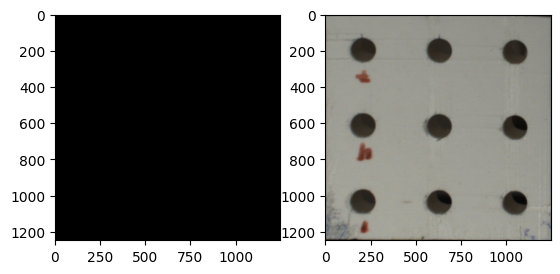

Processing image filepath: images_17112025/pose07_color01\1.bmp


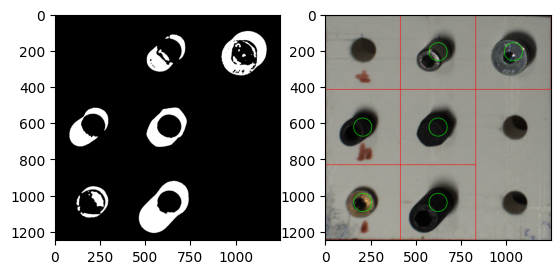

Processing image filepath: images_17112025/pose07_color01\2.bmp


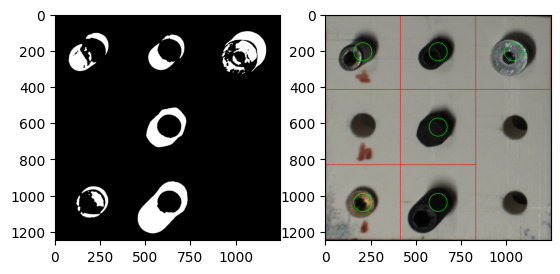

Processing image filepath: images_17112025/pose07_color01\3.bmp


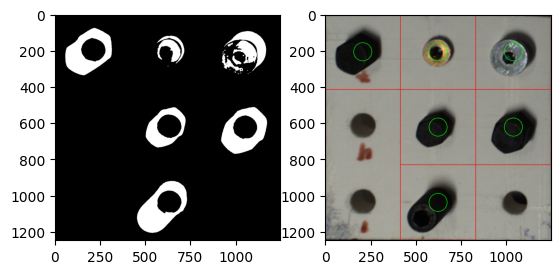

Processing image filepath: images_17112025/pose07_color01\4.bmp


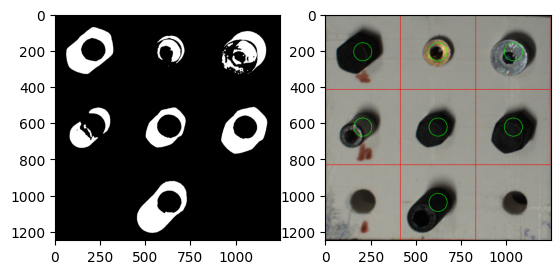

Processing image filepath: images_17112025/pose07_color01\5.bmp


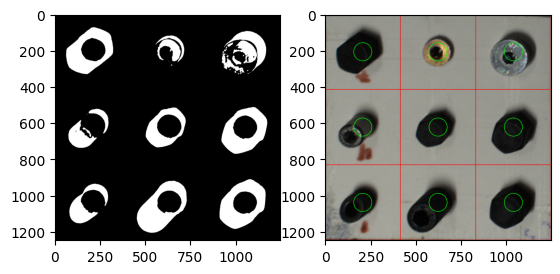

In [116]:
im_dir = "images_17112025/pose07_color01"

image_bgr_01 = cv2.imread(os.path.join(im_dir, "0.bmp"))
screw_template_im_rgb, corners = detect_screw_holder(image_bgr_01[...,::-1])

image_files = glob(os.path.join(im_dir, "*.bmp"))
for ifp in image_files:
    im_bgr = cv2.imread(ifp)
    print(f"Processing image filepath: {ifp}")
    screw_im_rgb = perspective_transform(im_bgr[...,::-1], corners, 416*3)
    detect_screw(screw_template_im_rgb, screw_im_rgb, corners, min_diff=1000)